In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sess = tf.Session()

train, test = tf.keras.datasets.mnist.load_data()
x_train = train[0]/255.
x_train = x_train[..., None]


In [2]:
latent = 49
img_size = (28, 28, 1)
classes = 10


def conv_layer(inp, filters, kernel_size=(3, 3), dropout=0, transpose=False, **kwargs):
    out = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same', **kwargs)(inp)
    if transpose:
        out = tf.keras.layers.Conv2DTranspose(filters, kernel_size=kernel_size, padding='valid', **kwargs)(inp)
    if dropout:
        out = tf.keras.layers.Dropout(rate=dropout)(out)
    out = tf.keras.layers.PReLU(shared_axes=[1, 2])(out)
    return out


# Define discriminator
def get_discriminator(img_dim=(28, 28, 1), class_dim=10, filters=32):
    constraint = tf.keras.constraints.MinMaxNorm(min_value=1.0, max_value=5.0)
    non_neg = tf.keras.constraints.NonNeg()
    
    x_input = tf.keras.layers.Input(img_dim)

    d = conv_layer(x_input, filters=filters, kernel_constraint=non_neg)
    d = conv_layer(d, filters=filters, kernel_constraint=non_neg)
    d = conv_layer(d, filters=filters, strides=(2, 2), kernel_constraint=non_neg)
    d = conv_layer(d, filters=filters, strides=(2, 2), kernel_constraint=non_neg)
    d = tf.keras.layers.Flatten()(d)
    d = tf.keras.layers.Dense(class_dim, activation='relu', kernel_constraint=non_neg)(d)

    y_input = tf.keras.layers.Input(img_dim)
    dy = conv_layer(y_input, filters=filters, kernel_constraint=non_neg)
    dy = conv_layer(dy, filters=filters, kernel_constraint=non_neg)
    dy = conv_layer(dy, filters=filters, strides=(2, 2), kernel_constraint=non_neg)
    dy = conv_layer(dy, filters=filters, strides=(2, 2), kernel_constraint=non_neg)
    dy = tf.keras.layers.Flatten()(dy)
    dy = tf.keras.layers.Dense(class_dim, activation='relu', kernel_constraint=non_neg)(dy)

    out = tf.keras.layers.Concatenate()([d, dy])
    out = tf.keras.layers.Dense(256, activation='relu', kernel_constraint=non_neg)(out)
    out = tf.keras.layers.Dense(1, activation='relu', use_bias=False, kernel_constraint=non_neg)(out)
    
    r = conv_layer(x_input, filters=filters, strides=(4, 4), kernel_constraint=non_neg)
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dense(1, activation='relu', use_bias=False, kernel_constraint=non_neg)(r)
    
    out = tf.keras.layers.Add()([out, r])
    

    discriminator = tf.keras.Model(inputs=[x_input, y_input], outputs=out)
    return discriminator

disc = get_discriminator()
dvars = disc.trainable_variables

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
class gradient_descent(tf.keras.layers.Layer):
    def __init__(self, discriminator, iterations=20, eta=1e-4, sigma=1e-2):
        super(gradient_descent, self).__init__()
        self.iterations = iterations
        self.eta = eta
        self.discriminator = discriminator
        self.sigma = sigma

    def build(self, input_shape):
        # Build gradients here for hopefully faster execution
        self.discriminator.trainable = False
        pass


    def call(self, input):
        out = input[0]
        y = input[1]
        #tik = self.discriminator([out, y])
        err = [self.discriminator([out, y])]
        for iteration in range(self.iterations):
            grads = tf.gradients(self.discriminator([out, y]), out)[0]
            out = out - self.eta*grads 
            err.append(self.discriminator([out, y]))
        return out


In [4]:
def get_generator(discriminator, K=10, img_dim=(28, 28, 1), filters=32):
    y_input = tf.keras.layers.Input(img_dim)
    d = conv_layer(y_input, filters=filters)
    d = conv_layer(d, filters=filters)
    d = conv_layer(d, filters=filters)
    d = conv_layer(d, filters=filters)
    x0 = conv_layer(d, filters=1)
    
    # Gradient descent
    eta = 1e-1
    out = gradient_descent(discriminator, eta=eta)([x0, y_input])
        
    generator = tf.keras.Model(inputs=y_input, outputs=[out, x0])
    return generator

In [5]:
gen = get_generator(disc)
gvars = gen.trainable_variables

In [6]:
# Discriminator tries to map x_true to output 1 and generator_out to output 0
# Generator tries to find images such that discriminator thinks they are output 1
LAM = 1e1
lr = 1e-4

x = tf.placeholder(tf.float32, (None, ) + img_size)
y = tf.placeholder(tf.float32, (None, ) + img_size)

line = tf.placeholder(tf.float32, (None, 1, 1, 1))

x_gen = gen(y)[0]
x_init = gen(y)[1]
x_line = x*line + x_gen*(1-line)


lip = LAM*sum([(tf.reduce_mean(g**2)-1)**2 for g in tf.gradients(disc([x_line, y]), [x_line, y])])

loss_disc = tf.reduce_mean(-disc([x_gen, y]) + disc([x, y]) + lip)
loss_gen = tf.reduce_mean(disc([x_gen, y]))


opt = tf.train.AdamOptimizer(learning_rate=lr)

grads_gen, _ = tf.clip_by_global_norm(tf.gradients(loss_gen, gvars), 1.)
grads_disc, _ = tf.clip_by_global_norm(tf.gradients(loss_disc, dvars), 1.)

train_gen = opt.apply_gradients(zip(grads_gen, gvars))
train_disc = opt.apply_gradients(zip(grads_disc, dvars))

############
# Active gradients

total_gen = int(np.sum([np.prod(t.shape) for t in gvars]))
active_gen = sum([tf.count_nonzero(grad) for grad in grads_gen if grad is not None])/total_gen

total_disc = int(np.sum([np.prod(t.shape) for t in dvars]))
active_disc = sum([tf.count_nonzero(grad) for grad in grads_disc if grad is not None])/total_disc

sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.


In [7]:
def generate_batch(batch_size=8):
    x = x_train[np.random.choice(60000, batch_size), ...]
    y = x + np.random.normal(0, 0.2, x.shape)
    return x, y

### Epoch 0 ###
[ 393.90103149  157.3598938 ].386559, Gen: 220.945297


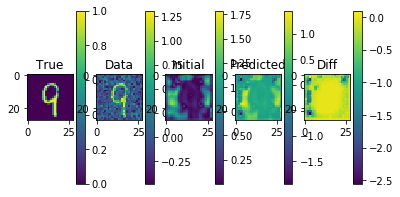

###############
### Epoch 1 ###
[ 1712769.5           12790.12207031], Gen: 1235.046509


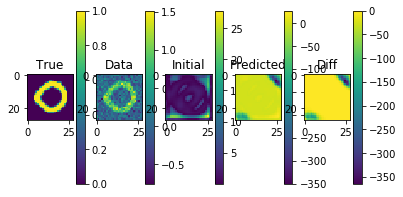

###############
### Epoch 2 ###
[  1.04503400e+08   1.33812312e+05]000000, Gen: 66743.867188


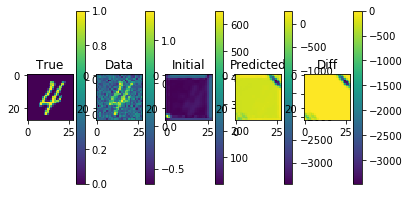

###############
### Epoch 3 ###
[  1.16539469e+09   1.25918740e+07].000000, Gen: 10959240.000000


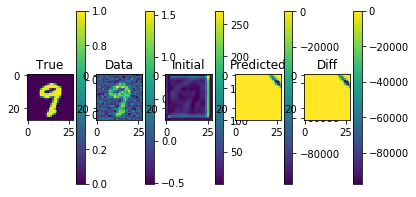

###############
### Epoch 4 ###
[  5.34446899e+09   1.88049340e+07]312.000000, Gen: 122293056.000000


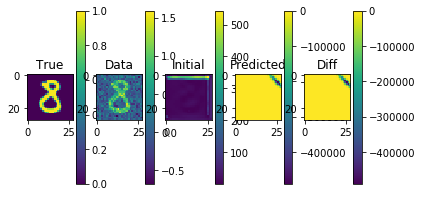

###############
### Epoch 5 ###


KeyboardInterrupt: 

In [13]:
epochs = 50
N = 60000
batch_size = 32
ncritic = 5

for epoch in range(epochs):
    LOSSD = []
    LOSSG = []
    print("### Epoch %d ###" % epoch)

    for batch in range(N // batch_size):
        CRITIC = []
        for i in range(ncritic):
            xinp, yinp = generate_batch(batch_size=batch_size)
            t = np.random.uniform(0, 1, (batch_size, 1, 1, 1))
            fd = {x: xinp,
                 y: yinp,
                 line: t}
            ld, _ = sess.run([loss_disc, train_disc], feed_dict=fd)
            CRITIC.append(ld)
            
        _, yinp = generate_batch(batch_size=batch_size)
        lg, _ = sess.run([loss_gen, train_gen], feed_dict={y: yinp})

        LOSSG.append(lg)
        LOSSD.append(np.mean(CRITIC))
        print("Progress: %f, Disc: %f, Gen: %f" % ((batch+1)*batch_size/N, np.mean(LOSSD), np.mean(LOSSG)), end='\r')
    
    xinp, yinp = generate_batch(batch_size=1)
    gx = sess.run([x_init, x_gen], feed_dict={y: yinp})
    dx = sess.run(disc([x, y]), feed_dict={y: np.concatenate([yinp, yinp]), x: np.concatenate(gx)})
    print(dx.flatten())
    plt.subplot(151)
    plt.imshow(xinp[0, ..., 0])
    plt.title("True")
    plt.colorbar()
    
    plt.subplot(152)
    plt.imshow(yinp[0, ..., 0])
    plt.title("Data")
    plt.colorbar()

    plt.subplot(153)
    plt.imshow(gx[0][0, ..., 0])
    plt.title("Initial")
    plt.colorbar()
    
    plt.subplot(154)
    plt.imshow(gx[1][0, ..., 0])
    plt.title("Predicted")
    plt.colorbar()
    
    plt.subplot(155)
    plt.imshow(gx[1][0, ..., 0] - gx[0][0, ..., 0])
    plt.title("Diff")
    plt.colorbar()

    plt.show()

    print("###############")

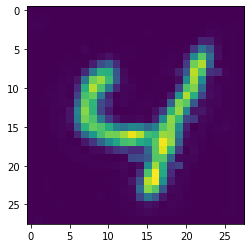

In [10]:
plt.imshow(gx[0][0, ..., 0])

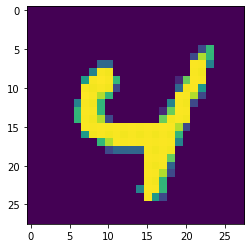

In [12]:
plt.imshow(xinp[0, ..., 0])

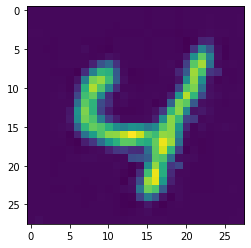

In [11]:
plt.imshow(gx[1][0, ..., 0])

In [ ]:
class gradient_descent(tf.keras.layers.Layer):
    def __init__(self, discriminator, iterations=10, eta=1e-3, sigma=0.1):
        super(gradient_descent, self).__init__()
        self.iterations = iterations
        self.eta = eta
        self.discriminator = discriminator
        self.sigma = sigma

    def build(self, input_shape):
        # Build gradients here for hopefully faster execution
        self.discriminator.trainable = False
        self.x = tf.placeholder(tf.float32, discriminator.inputs[0].shape)
        self.y = tf.placeholder(tf.float32, discriminator.inputs[1].shape)
        self.grads = tf.gradients(self.discriminator([self.x, self.y]), self.x)[0]
        self.update = self.x - eta * self.grads
        pass


    def call(self, input):
        out = input[0]
        y = input[1]
        #tik = self.discriminator([out, y])
        err = [self.discriminator([out, y])]
        for iteration in range(self.iterations):
            self.update_ops
            err.append(self.discriminator([out, y]))
        return out


In [7]:
import tensorflow as tf
import numpy as np

sess = tf.Session()
s = (1, 8, 8, 1)
xinp = np.random.normal(1, 1, (1, 8, 8, 1))
np.sum(xinp**2)

105.26079785313866

In [8]:
xvar = tf.Variable(tf.zeros(s), trainable=False)
l = tf.reduce_sum(xvar**2)
grads = tf.gradients(l, xvar)[0]
update = xvar.assign(xvar - 0.01*grads)
err = [l]
for k in range(10):
    update
    err.append(l)
    
sess.run(tf.global_variables_initializer())

In [9]:
xvar

<tf.Variable 'Variable_1:0' shape=(1, 8, 8, 1) dtype=float32_ref>

In [10]:
xout, g, e = sess.run([xvar, grads, err], feed_dict={xvar: xinp})

In [12]:
opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [14]:
opt.minimize(l, var_list=x)

NameError: name 'x' is not defined

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sess = tf.Session()
size = 512
s = (None, size, size, 1)

class gradient_descent(tf.keras.layers.Layer):
    def __init__(self, discriminator, iterations=50, eta=1e-2, sigma=0.1):
        super(gradient_descent, self).__init__()
        self.iterations = iterations
        self.eta = eta
        self.discriminator = discriminator
        self.sigma = sigma

    def build(self, input_shape):
        # TODO: Build gradients update
        # self.discriminator.trainable = False
        pass


    def call(self, input):
        x = input[0]
        y = input[1]
        err = [self.discriminator([x, y])]
        for iteration in range(self.iterations):
            grads = tf.gradients(self.discriminator([x, y]), x)[0]
            x = x - self.eta*grads
            err.append(self.discriminator([x, y]))
        return x, err


In [44]:
def disc(L):
    x = L[0]
    y = L[1]
    return tf.reduce_sum(tf.squared_difference(x, y))

In [45]:
inp = [tf.placeholder(tf.float32, s), tf.placeholder(tf.float32, s)]
out = gradient_descent(disc)(inp)

In [46]:
xinp = np.zeros((8, size, size, 1))
yinp = np.ones((8, size, size,1))

In [47]:
xout, errout = sess.run(out, feed_dict={inp[0]: xinp, inp[1]: yinp})

In [48]:
xout

array([[[[ 0.63583016],
         [ 0.63583016],
         [ 0.63583016],
         ..., 
         [ 0.63583016],
         [ 0.63583016],
         [ 0.63583016]],

        [[ 0.63583016],
         [ 0.63583016],
         [ 0.63583016],
         ..., 
         [ 0.63583016],
         [ 0.63583016],
         [ 0.63583016]],

        [[ 0.63583016],
         [ 0.63583016],
         [ 0.63583016],
         ..., 
         [ 0.63583016],
         [ 0.63583016],
         [ 0.63583016]],

        ..., 
        [[ 0.63583016],
         [ 0.63583016],
         [ 0.63583016],
         ..., 
         [ 0.63583016],
         [ 0.63583016],
         [ 0.63583016]],

        [[ 0.63583016],
         [ 0.63583016],
         [ 0.63583016],
         ..., 
         [ 0.63583016],
         [ 0.63583016],
         [ 0.63583016]],

        [[ 0.63583016],
         [ 0.63583016],
         [ 0.63583016],
         ..., 
         [ 0.63583016],
         [ 0.63583016],
         [ 0.63583016]]],


       [[[ 0.63583

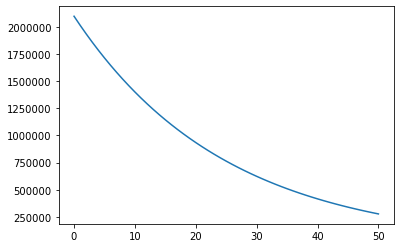

In [49]:
plt.plot(errout)

In [50]:
errout

[2097152.0,
 2014104.1,
 1934346.1,
 1857746.1,
 1784179.9,
 1713525.9,
 1645670.1,
 1580501.9,
 1517913.9,
 1457804.1,
 1400075.1,
 1344632.1,
 1291384.9,
 1240246.1,
 1191132.1,
 1143963.9,
 1098662.9,
 1055155.9,
 1013371.1,
 973242.06,
 934701.94,
 897687.06,
 862139.0,
 827998.25,
 795209.56,
 763719.25,
 733476.06,
 704430.44,
 676534.94,
 649744.06,
 624014.44,
 599303.44,
 575571.0,
 552778.44,
 530888.44,
 509865.03,
 489674.53,
 470283.53,
 451660.47,
 433774.5,
 416597.03,
 400099.88,
 384255.97,
 369039.47,
 354425.47,
 340390.22,
 326910.84,
 313965.16,
 301532.16,
 289591.47,
 278123.53]

In [39]:
graph = tf.get_default_graph()

In [40]:
graph

In [41]:
graph.

''

In [42]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['Placeholder',
 'Placeholder_1',
 'gradient_descent/SquaredDifference',
 'gradient_descent/Const',
 'gradient_descent/Mean',
 'gradient_descent/SquaredDifference_1',
 'gradient_descent/Const_1',
 'gradient_descent/Mean_1',
 'gradient_descent/gradients/Shape',
 'gradient_descent/gradients/grad_ys_0',
 'gradient_descent/gradients/Fill',
 'gradient_descent/gradients/gradient_descent/Mean_1_grad/Reshape/shape',
 'gradient_descent/gradients/gradient_descent/Mean_1_grad/Reshape',
 'gradient_descent/gradients/gradient_descent/Mean_1_grad/Shape',
 'gradient_descent/gradients/gradient_descent/Mean_1_grad/Tile',
 'gradient_descent/gradients/gradient_descent/Mean_1_grad/Shape_1',
 'gradient_descent/gradients/gradient_descent/Mean_1_grad/Shape_2',
 'gradient_descent/gradients/gradient_descent/Mean_1_grad/Const',
 'gradient_descent/gradients/gradient_descent/Mean_1_grad/Prod',
 'gradient_descent/gradients/gradient_descent/Mean_1_grad/Const_1',
 'gradient_descent/gradients/gradient_descent/Mean_1_g